## Start of the ML model training script

### 01. Load the dataset

In [ ]:
import pandas as pd

# Load the dataset
students_df = pd.read_csv("synthetic_student_dataset.csv")

# View the first 5 rows
students_df.head()

,Student_ID,Z_Score,Stream,District,Gender,Preferred_Courses,Selected_Course
0,1,1.986,Commerce,Kandy,M,['SPORTS SCIENCE & MANAGEMENT # (University o...,"MANAGEMENT (Eastern University, Sri Lanka)"
1,2,3.657,Arts,Colombo,M,"['SOCIAL WORK * (University of Peradeniya)', '...",SOCIAL WORK * (University of Peradeniya)
2,3,3.023,Arts,Galle,M,"['ARTS * (University of Peradeniya)', 'ARTS * ...",MUSIC # (Swami Vipulananda Institute of Aest...
3,4,2.636,Arts,Kandy,M,"['ARTS * (University of Peradeniya)', 'ARTS (S...",ART & DESIGN # (University of Jaffna)
4,5,1.352,Physical Science,Anuradhapura,M,"['PHYSICAL SCIENCE (University of Kelaniya)', ...",COMPUTER SCIENCE (University of Kelaniya)


In [381]:
# Load the z-score cutoff dataset
cutoff_df = pd.read_csv("cutoff_2023.csv")

cutoff_df.head()

,COURSE OF STUDY DISTRICT,MEDICINE (University of Colombo),MEDICINE (University of Peradeniya),MEDICINE (University of Sri Jayewardenepura),MEDICINE (University of Kelaniya),MEDICINE (University of Jaffna),MEDICINE (University of Ruhuna),MEDICINE (University of Moratuwa),"MEDICINE (Eastern University, Sri Lanka)",MEDICINE (Rajarata University of Sri Lanka),...,MUSIC # (University of the Visual & Performing Arts),DANCE # (University of the Visual & Performing Arts),DRAMA & THEATRE # (University of the Visual & Performing Arts),ART & DESIGN # (University of Jaffna),MUSIC # (University of Jaffna),DANCE # (University of Jaffna),VISUAL & TECHNOLOGICAL ARTS # (Swami Vipulananda Institute of Aesthetic Studies),MUSIC # (Swami Vipulananda Institute of Aesthetic Studies),DANCE # (Swami Vipulananda Institute of Aesthetic Studies),DRAMA & THEATRE # (Swami Vipulananda Institute of Aesthetic Studies)
0,COLOMBO,2.4516,2.2279,2.1465,2.0526,1.879,1.9559,1.8732,NQC,1.8772,...,0.2977,0.7756,0.9184,NQC,0.0672,0.0655,NQC,NQC,0.2439,-0.3643
1,GAMPAHA,2.4412,2.2147,2.1566,2.0517,1.7278,1.955,1.8707,1.6406,1.8547,...,0.2155,0.8958,0.7873,1.2643,NQC,-0.4526,NQC,NQC,NQC,NQC
2,KALUTARA,2.4446,2.2204,2.1474,2.0514,1.784,1.9559,1.8732,1.7783,1.8995,...,0.5951,0.9194,0.4765,NQC,0.4778,-0.5592,-0.4372,0.6484,0.7635,0.0772
3,MATALE,2.4981,2.215,2.1943,2.0612,1.7073,1.9778,NQC,1.6524,1.8604,...,0.9793,0.9385,1.0223,0.5481,0.274,0.4399,0.467,-0.2345,-0.1395,0.4405
4,KANDY,2.5501,2.2216,2.1512,2.0545,1.8169,1.9598,1.8827,NQC,1.8509,...,0.8065,0.9312,0.5006,NQC,0.1218,-0.0591,-0.0373,-0.5822,-0.6296,-0.1319


### 02. Data Preprocessing

In [382]:
# Convert wide format to long format
cutoff_long = cutoff_df.melt(
    id_vars="COURSE OF STUDY DISTRICT",
    var_name="Degree",
    value_name="Cutoff_Z"
)
cutoff_long.rename(columns={"COURSE OF STUDY DISTRICT": "District"}, inplace=True)

# Convert cutoff values to numeric and clean
cutoff_long['Cutoff_Z'] = pd.to_numeric(cutoff_long['Cutoff_Z'], errors='coerce')
cutoff_long.dropna(subset=['Cutoff_Z'], inplace=True)

cutoff_long.head()

,District,Degree,Cutoff_Z
0,COLOMBO,MEDICINE (University of Colombo),2.4516
1,GAMPAHA,MEDICINE (University of Colombo),2.4412
2,KALUTARA,MEDICINE (University of Colombo),2.4446
3,MATALE,MEDICINE (University of Colombo),2.4981
4,KANDY,MEDICINE (University of Colombo),2.5501


In [383]:
import ast

# Convert Preferred_Courses from stringified list → actual list
students_df['Preferred_Courses'] = students_df['Preferred_Courses'].apply(ast.literal_eval)

# Explode so each student-course preference is one row
exploded_df = students_df.explode('Preferred_Courses')

# Rename for clarity
exploded_df.rename(columns={'Preferred_Courses': 'Degree'}, inplace=True)

exploded_df.head()

,Student_ID,Z_Score,Stream,District,Gender,Degree,Selected_Course
0,1,1.986,Commerce,Kandy,M,SPORTS SCIENCE & MANAGEMENT # (University of ...,"MANAGEMENT (Eastern University, Sri Lanka)"
0,1,1.986,Commerce,Kandy,M,"MANAGEMENT (Eastern University, Sri Lanka)","MANAGEMENT (Eastern University, Sri Lanka)"
0,1,1.986,Commerce,Kandy,M,MANAGEMENT (University of Colombo),"MANAGEMENT (Eastern University, Sri Lanka)"
0,1,1.986,Commerce,Kandy,M,ENTREPRENEURSHIP AND MANAGEMENT # (Uva Wellass...,"MANAGEMENT (Eastern University, Sri Lanka)"
0,1,1.986,Commerce,Kandy,M,COMMERCE (South Eastern University of Sri Lanka),"MANAGEMENT (Eastern University, Sri Lanka)"


In [384]:
import re

def normalize_degree_name(name):
    name = re.sub(r'[*#–-]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip().lower()

# Normalize degree names
cutoff_long['Degree'] = cutoff_long['Degree'].apply(normalize_degree_name)
cutoff_long['District'] = cutoff_long['District'].str.lower().str.strip()
exploded_df['Degree'] = exploded_df['Degree'].apply(normalize_degree_name)
exploded_df['Selected_Course'] = exploded_df['Selected_Course'].apply(normalize_degree_name)
exploded_df['District'] = exploded_df['District'].str.lower().str.strip()

cutoff_long.head()

,District,Degree,Cutoff_Z
0,colombo,medicine (university of colombo),2.4516
1,gampaha,medicine (university of colombo),2.4412
2,kalutara,medicine (university of colombo),2.4446
3,matale,medicine (university of colombo),2.4981
4,kandy,medicine (university of colombo),2.5501


In [385]:
exploded_df.head()

,Student_ID,Z_Score,Stream,District,Gender,Degree,Selected_Course
0,1,1.986,Commerce,kandy,M,sports science & management (university of sri...,"management (eastern university, sri lanka)"
0,1,1.986,Commerce,kandy,M,"management (eastern university, sri lanka)","management (eastern university, sri lanka)"
0,1,1.986,Commerce,kandy,M,management (university of colombo),"management (eastern university, sri lanka)"
0,1,1.986,Commerce,kandy,M,entrepreneurship and management (uva wellassa ...,"management (eastern university, sri lanka)"
0,1,1.986,Commerce,kandy,M,commerce (south eastern university of sri lanka),"management (eastern university, sri lanka)"


In [ ]:
merged_df = exploded_df.merge(
    cutoff_long,
    on=['District', 'Degree'],
    how='left'
)

# Drop courses not offered in that district
merged_df.dropna(subset=['Cutoff_Z'], inplace=True)

# Keep only eligible rows
eligible_df = merged_df[merged_df['Z_Score'] >= merged_df['Cutoff_Z']]
eligible_df.head()

,Student_ID,Z_Score,Stream,District,Gender,Degree,Selected_Course,Cutoff_Z
0,1,1.986,Commerce,kandy,M,sports science & management (university of sri...,"management (eastern university, sri lanka)",0.9146
1,1,1.986,Commerce,kandy,M,"management (eastern university, sri lanka)","management (eastern university, sri lanka)",1.2984
2,1,1.986,Commerce,kandy,M,management (university of colombo),"management (eastern university, sri lanka)",1.7370
3,1,1.986,Commerce,kandy,M,entrepreneurship and management (uva wellassa ...,"management (eastern university, sri lanka)",1.2494
4,1,1.986,Commerce,kandy,M,commerce (south eastern university of sri lanka),"management (eastern university, sri lanka)",1.2476


In [387]:
eligible_df = eligible_df.copy()  # Safe copy before modifying
eligible_df['Label'] = (
    eligible_df['Degree'] == eligible_df['Selected_Course'].apply(normalize_degree_name)
).astype(int)

eligible_df.head()

,Student_ID,Z_Score,Stream,District,Gender,Degree,Selected_Course,Cutoff_Z,Label
0,1,1.986,Commerce,kandy,M,sports science & management (university of sri...,"management (eastern university, sri lanka)",0.9146,0
1,1,1.986,Commerce,kandy,M,"management (eastern university, sri lanka)","management (eastern university, sri lanka)",1.2984,1
2,1,1.986,Commerce,kandy,M,management (university of colombo),"management (eastern university, sri lanka)",1.7370,0
3,1,1.986,Commerce,kandy,M,entrepreneurship and management (uva wellassa ...,"management (eastern university, sri lanka)",1.2494,0
4,1,1.986,Commerce,kandy,M,commerce (south eastern university of sri lanka),"management (eastern university, sri lanka)",1.2476,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Normalize strings in students_df and cutoff_long first
students_df['Stream'] = students_df['Stream'].str.strip().str.title()
students_df['District'] = students_df['District'].str.lower().str.strip()
students_df['Gender'] = students_df['Gender'].str.strip().str.upper()

cutoff_long['Degree'] = cutoff_long['Degree'].str.strip().str.lower()
cutoff_long['District'] = cutoff_long['District'].str.lower().str.strip()

# Combine unique categories from both datasets for fitting encoders
all_streams = pd.Series(
    pd.concat([students_df['Stream'], eligible_df['Stream']])
).str.strip().str.title().unique()

all_districts = pd.Series(
    pd.concat([students_df['District'], cutoff_long['District'], eligible_df['District']])
).str.lower().str.strip().unique()

all_genders = pd.Series(
    pd.concat([students_df['Gender'], eligible_df['Gender']])
).str.strip().str.upper().unique()

all_degrees = cutoff_long['Degree'].unique()

# Initialize encoders
le_stream = LabelEncoder()
le_district = LabelEncoder()
le_gender = LabelEncoder()
le_degree = LabelEncoder()

# Fit encoders on combined unique categories
le_stream.fit(all_streams)
le_district.fit(all_districts)
le_gender.fit(all_genders)
le_degree.fit(all_degrees)

# Normalize eligible_df columns to match encoder input format
eligible_df['Stream'] = eligible_df['Stream'].str.strip().str.title()
eligible_df['District'] = eligible_df['District'].str.lower().str.strip()
eligible_df['Gender'] = eligible_df['Gender'].str.strip().str.upper()
eligible_df['Degree'] = eligible_df['Degree'].str.strip().str.lower()

# Apply transforms
eligible_df['Stream'] = le_stream.transform(eligible_df['Stream'])
eligible_df['District'] = le_district.transform(eligible_df['District'])
eligible_df['Gender'] = le_gender.transform(eligible_df['Gender'])
eligible_df['Degree_Encoded'] = le_degree.transform(eligible_df['Degree'])

print("Streams fitted in encoder:", le_stream.classes_)
print("Districts fitted in encoder:", le_district.classes_)
print("Genders fitted in encoder:", le_gender.classes_)
print("Degrees fitted in encoder:", le_degree.classes_)

Streams fitted in encoder: ['Arts' 'Bio Science' 'Commerce' 'Physical Science' 'Technology']
Districts fitted in encoder: ['ampara' 'anuradhapura' 'badulla' 'batticaloa' 'colombo' 'galle'
 'gampaha' 'hambantota' 'jaffna' 'kalutara' 'kandy' 'kegalle'
 'kilinochchi' 'kurunegala' 'mannar' 'matale' 'matara' 'monaragala'
 'mullaitivu' 'nuwara eliya' 'polonnaruwa' 'puttalam' 'ratnapura'
 'trincomalee' 'vavuniya']
Genders fitted in encoder: ['F' 'M']
Degrees fitted in encoder: ['accounting information systems (university of kelaniya)'
 'agri business management (university of ruhuna)'
 'agricultural resource management and technology (university of ruhuna)'
 'agricultural technology & management (university of peradeniya)'
 'agriculture (eastern university, sri lanka)'
 'agriculture (rajarata university of sri lanka)'
 'agriculture (sabaragamuwa university of sri lanka)'
 'agriculture (university of jaffna)'
 'agriculture (wayamba university of sri lanka)'
 'animal production and food technol

### 03. Train/test spltting

In [389]:
from sklearn.model_selection import train_test_split

unique_ids = eligible_df['Student_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = eligible_df[eligible_df['Student_ID'].isin(train_ids)]
test_df = eligible_df[eligible_df['Student_ID'].isin(test_ids)]

### 04. Model Training

In [ ]:
import lightgbm as lgb

features = ['Z_Score', 'Stream', 'District', 'Gender', 'Cutoff_Z', 'Degree_Encoded']
X_train = train_df[features].apply(pd.to_numeric)
y_train = train_df['Label']
group_train = train_df.groupby('Student_ID').size().to_list()

ltr_model = lgb.LGBMRanker(objective='lambdarank')
ltr_model.fit(X_train, y_train, group=group_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 317928, number of used features: 6


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### 05. Metrics (Model Performance)

/tmp/ipykernel_19920/1833838584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Score'] = ltr_model.predict(X_test)


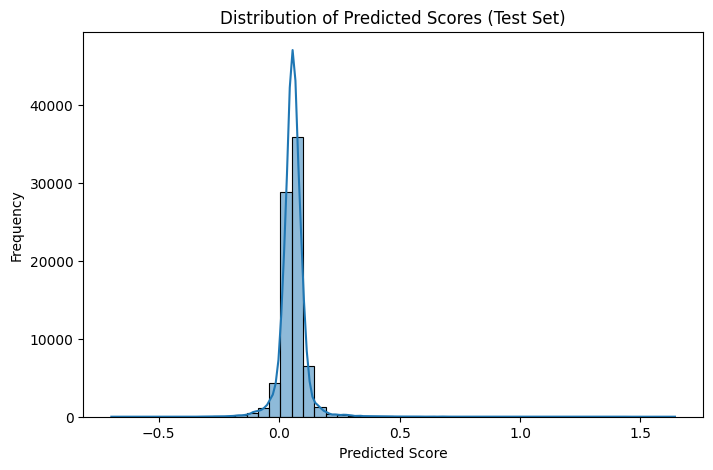

In [391]:
import matplotlib.pyplot as plt
import seaborn as sns

X_test = test_df[features].apply(pd.to_numeric)
y_test = test_df['Label']
group_test = test_df.groupby('Student_ID').size().to_list()

# Predict
test_df['Predicted_Score'] = ltr_model.predict(X_test)

# Visualization
plt.figure(figsize=(8, 5))
sns.histplot(test_df['Predicted_Score'], kde=True, bins=50)
plt.title("Distribution of Predicted Scores (Test Set)")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.show()

In [392]:
import numpy as np
from sklearn.metrics import ndcg_score

# Ensure 'Predicted_Score' is already calculated on test_df
# test_df['Predicted_Score'] = ltr_model.predict(X_test) # This line is already in your notebook

ndcg_scores = []

# Iterate through each unique student in the test set
for student_id in test_df['Student_ID'].unique():
    student_data = test_df[test_df['Student_ID'] == student_id]

    # True relevance scores (Label column)
    # Reshape to 2D array as required by ndcg_score for a single query
    y_true_student = student_data['Label'].values.reshape(1, -1)

    # Predicted scores
    # Reshape to 2D array
    y_score_student = student_data['Predicted_Score'].values.reshape(1, -1)

    # Calculate NDCG. Handle cases where there might be no relevant items
    # or if the predicted scores are all the same, leading to division by zero.
    # ndcg_score will return NaN if y_true is all zeros and the ideal DCG is 0.
    if y_true_student.sum() > 0 and len(np.unique(y_score_student)) > 1:
        score = ndcg_score(y_true_student, y_score_student)
        ndcg_scores.append(score)
    elif y_true_student.sum() == 0:
        # If there are no relevant items for this student, NDCG is 1 by convention if no relevant items are predicted, or 0 if some irrelevant items are ranked high.
        # For simplicity, we can skip or assign 0 if no relevant items are in the true set.
        ndcg_scores.append(0.0) # If no relevant items, it's not "accurate" in finding them.
    else: # y_true_student.sum() > 0 but len(np.unique(y_score_student)) <= 1 (all predicted scores are the same)
        # If all predicted scores are the same, ranking is arbitrary.
        # This will depend on tie-breaking, but essentially it's a poor ranking.
        ndcg_scores.append(0.0)


# Calculate the average NDCG score across all students
average_ndcg = np.mean(ndcg_scores)
print(f"Average NDCG Score: {average_ndcg}")

Average NDCG Score: 0.504330494952634


In [394]:
# Assuming test_df has 'Predicted_Score' calculated and 'Label' column
import pandas as pd

# Get a list of unique student IDs in the test set
unique_student_ids = test_df['Student_ID'].unique()

# Pick a few sample student IDs
sample_ids = unique_student_ids[:3] # You can change this to look at more or specific IDs

for student_id in sample_ids:
    print(f"\n--- Predictions for Student ID: {student_id} ---")
    student_data = test_df[test_df['Student_ID'] == student_id].copy()

    # Sort by predicted score to see the ranking
    student_data_sorted = student_data.sort_values(by='Predicted_Score', ascending=False)

    # Display relevant columns
    print(student_data_sorted[['Degree', 'Label', 'Predicted_Score']].head(10)) # Show top 10

    # Check for score variance
    if len(student_data_sorted['Predicted_Score'].unique()) <= 1:
        print("Note: All predicted scores are identical for this student, preventing effective ranking.")


--- Predictions for Student ID: 10 ---
                                               Degree  Label  Predicted_Score
46           physical science (university of colombo)      0         0.104778
47          engineering (em) (university of moratuwa)      0         0.057159
49          physical science (university of kelaniya)      0         0.049688
48  industrial statistics & mathematical finance (...      1         0.049649

--- Predictions for Student ID: 43 ---
                                                Degree  Label  Predicted_Score
210  animal production and food technology (uva wel...      1         0.072650
212  financial mathematics and industrial statistic...      0         0.067086
213   information systems (university of sabaragamuwa)      0         0.021380

--- Predictions for Student ID: 57 ---
                                                Degree  Label  Predicted_Score
280  physical science (university of sri jayewarden...      1         0.056299
284          phy

### 06. Testing

In [395]:
def recommend_courses(z_score, stream, district, gender, top_n=5):
    # Normalize input to match encoder
    stream = stream.strip().title()
    district = district.strip().lower()
    gender = gender.strip().upper()

    # Encode
    stream_encoded = le_stream.transform([stream])[0]
    district_encoded = le_district.transform([district])[0]
    gender_encoded = le_gender.transform([gender])[0]

    # Filter eligible degrees in that district
    subset = cutoff_long[cutoff_long['District'] == district].copy()
    subset = subset[subset['Cutoff_Z'] <= z_score]

    # Add features
    subset['Z_Score'] = z_score
    subset['Stream'] = stream_encoded
    subset['District'] = district_encoded
    subset['Gender'] = gender_encoded

    # Add Degree_Encoded for the degrees in this subset
    subset['Degree_Encoded'] = le_degree.transform(subset['Degree'])

    # Select all features used during training
    X_input = subset[['Z_Score', 'Stream', 'District', 'Gender', 'Cutoff_Z', 'Degree_Encoded']].apply(pd.to_numeric)

    # Predict
    subset['Score'] = ltr_model.predict(X_input)

    return subset.sort_values('Score', ascending=False)[['Degree', 'Score']].head(top_n)

recommend_courses(1.8282, 'Arts', 'Kurunegala', 'M')

,Degree,Score
4518,accounting information systems (university of ...,1.062224
868,applied sciences (bio.sc) (rajarata university...,0.320205
1568,applied sciences (phy.sc) (sabaragamuwa univer...,0.228413
118,medicine (university of jaffna),0.207438
268,medicine (wayamba university of sri lanka),0.195705
